# LOAD DATA

## HELPER FUNCTIONS

In [1]:
!pip install biopython seaborn
import numpy as np
from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import shutil

# Helper functions for data loading 
def wc(fn):
    return len(open(fn).readlines())

def gene_with_high_incidence(gene_wc, wc):
    return [g for g, c in gene_wc.items() if c >= wc * 1.0]


def create_gene_datasets(prefix_data_folder, output_data_folder):
    os.makedirs(output_data_folder, exist_ok=True)


    for ds_name, ds_values in data_files.items():
        # print(ds_name)
        gene_sequences_tt = {}
        wc_tt = {}
        gene_wc_tt = {}
        for var_seq_name, var_label_name, var_dest_folder in [("train_seq", "train_label", "train"), ("test_seq", "test_label", "test")]:
            gene_sequences = {}
            for cur_record in SeqIO.parse(prefix_data_folder + ds_values[var_seq_name], "fasta"):
                seq_name_gene = cur_record.name.split(';')[0]
                seq_name, seq_gene = seq_name_gene.split('_')
                # print(seq_gene)
                if seq_gene == '': continue
                if seq_gene not in gene_sequences: gene_sequences[seq_gene] = {}
                gene_sequences[seq_gene][seq_name] = cur_record.seq
            gene_sequences_tt[var_dest_folder] = gene_sequences
            wc_tt[var_dest_folder] = wc(prefix_data_folder + ds_values[var_label_name])
            gene_wc_tt[var_dest_folder] = {seq_gene:len(seq_name_seq) for seq_gene, seq_name_seq in gene_sequences.items()}

        gene_rich_set = set(gene_with_high_incidence(gene_wc_tt["test"], wc_tt["test"])) & set(gene_with_high_incidence(gene_wc_tt["train"], wc_tt["train"]))
        # for gr in gene_rich_set:
        #     print(gr, gene_wc_tt["train"][gr], wc_tt["train"], gene_wc_tt["test"][gr], wc_tt["test"])
        for var_seq_name, var_label_name, var_dest_folder in [("train_seq", "train_label", "train"), ("test_seq", "test_label", "test")]:
            gene_sequences = gene_sequences_tt[var_dest_folder]
            newpath = output_data_folder + "/" + ds_name + "/" + var_dest_folder + "/"
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            shutil.copyfile(prefix_data_folder + ds_values[var_label_name], newpath + "labels.txt")

            for gene_name, seq_name_seq in gene_sequences.items():
                if gene_name in gene_rich_set:
                    with open(newpath + gene_name + ".fasta", "w") as f:
                        for n, s in seq_name_seq.items():
                            print(">" + n + "\n" + s, file = f)

# Helper function for loading gene sequences
def load_gene_data(folder, dataset, gene):
    '''
    loads genemic sequences and labels for train and test sets for a specific dataset and gene.
    Example:
      ds = load_gene_data("../data/ds1", "Klebsiella_pneumoniae_aztreonam", "acrR")
    here ds["train"] and ds["test"] both are a list of tuples of the form (gene, seq, label).

    '''

    pathogens = {}
    for tt in ["train", "test"]:
        pathogen_name_to_seq, pathogen_name_to_label = {}, {}
        for cur_record in SeqIO.parse(folder + "/" + dataset + "/" + tt + "/" + gene + ".fasta", "fasta"):
            pathogen_name_to_seq[cur_record.name] = str(cur_record.seq)

        for l in open(folder + "/" + dataset + "/" + tt + "/" + "labels" + ".txt"):
            x = l.strip().split('\t')
            pathogen_name_to_label[x[0]] = int(x[1])

        pathogens_tt = []
        for g, seq in pathogen_name_to_seq.items():
            if g in pathogen_name_to_label:
                pathogens_tt.append((g, seq.upper(), pathogen_name_to_label[g]))
        pathogens[tt] = pathogens_tt

    return pathogens

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.4 MB/s eta 0:00:0000:0100:01


## DATASET PATH

In [2]:
# Dataset file structure in the github
data_files = {
    "Klebsiella_pneumoniae_aztreonam":{
        "train_seq": "data/Klebsiella_pneumoniae_aztreonam/train_seq.txt",
        "test_label": "data/Klebsiella_pneumoniae_aztreonam/test_label.txt",
        "test_seq": "data/Klebsiella_pneumoniae_aztreonam/test_seq.txt",
        "train_label": "data/Klebsiella_pneumoniae_aztreonam/train_label.txt"
    }, 
    "Staphylococcus_aureus_cefoxitin":{
        "train_seq": "data/Staphylococcus_aureus_cefoxitin/train_seq.txt",
        "test_label": "data/Staphylococcus_aureus_cefoxitin/test_label.txt",
        "test_seq": "data/Staphylococcus_aureus_cefoxitin/test_seq.txt",
        "train_label": "data/Staphylococcus_aureus_cefoxitin/train_label.txt"
    }
}

## GIT CLONE

In [3]:
import os
directory = "seminar-dlmb-2025-summer-public"

if os.path.exists(directory) and os.listdir(directory):
    print(f"Directory {directory} exists and is non-empty.")
else:
    print(f"Directory {directory} does not exist or is empty.")
    !!git clone https://github.com/hzi-bifo/seminar-dlmb-2025-summer-public.git

Directory seminar-dlmb-2025-summer-public does not exist or is empty.


## LOAD DATA

In [4]:


working_directory = "/kaggle/working/seminar-dlmb-2025-summer-public"
# Creating our dataset
create_gene_datasets(f"{working_directory}/", f"{working_directory}/data/ds1")

# Loading the AMR prediction data
ds = load_gene_data(f"{working_directory}/data/ds1", "Staphylococcus_aureus_cefoxitin", "pbp4")

seq_train = [x[1] for x in ds["train"]]
y_train = [x[2] for x in ds["train"]]

seq_test = [x[1] for x in ds["test"]]
y_test = [x[2] for x in ds["test"]]

In [5]:
len(seq_train)

135

# IMPORT LIBRARIES AND RANDOM SEED

In [6]:
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import AutoTokenizer, AutoModelForMaskedLM
from matplotlib.gridspec import GridSpec
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

# HuggingFace Authentication (replace with your token)
HF_TOKEN = ""  # Add your token
os.environ["HUGGINGFACE_HUB_TOKEN"] = HF_TOKEN

print("✅ Environment setup complete!")

Using device: cuda
CUDA available: True
✅ Environment setup complete!


# CLASS DEFINITION

## DATASET CLASS

In [7]:
class AMRDataset(Dataset):
    """Custom Dataset for AMR Classification"""
    
    def __init__(self, sequences, labels, tokenizer, max_length=1000):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = str(self.sequences[idx])
        label = int(self.labels[idx])
        
        # Tokenize the sequence
        encoding = self.tokenizer(
            sequence,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## TRANSFORMER CLASS

In [8]:
class NucleotideTransformerClassifier(nn.Module):
    """
    Custom Classification wrapper for Nucleotide Transformer MLM model
    This follows the exact HuggingFace model loading pattern
    """
    
    def __init__(self, base_model, num_labels=2, hidden_dropout_prob=0.1):
        super().__init__()
        self.nucleotide_transformer = base_model
        self.num_labels = num_labels
        
        # Get hidden size from the model config
        self.hidden_size = base_model.config.hidden_size
        
        # Add classification head
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.classifier = nn.Linear(self.hidden_size, num_labels)
        
        # Initialize classifier weights
        self.classifier.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier.bias.data.zero_()
    
    def forward(self, input_ids, attention_mask=None, output_hidden_states=False):
        # Get outputs from the base nucleotide transformer
        outputs = self.nucleotide_transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True  # We need hidden states for classification
        )
        
        # Use CLS token representation (first token) for classification
        # Last hidden state: [batch_size, seq_len, hidden_size]
        last_hidden_state = outputs.hidden_states[-1]
        cls_representation = last_hidden_state[:, 0, :]  # CLS token
        
        # Apply dropout and classification
        pooled_output = self.dropout(cls_representation)
        logits = self.classifier(pooled_output)
        
        # Return in the same format as EsmForSequenceClassification
        return type('ClassificationOutput', (), {
            'logits': logits,
            'hidden_states': outputs.hidden_states if output_hidden_states else None,
            'last_hidden_state': last_hidden_state
        })()

## LOSS FUNCTION

In [9]:
class AggressiveFocalLoss(nn.Module):
    """
    Aggressive Focal Loss that forces confident predictions
    """
    def __init__(self, alpha=0.8, gamma=3.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # Calculate cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Calculate pt (probability of correct class)
        pt = torch.exp(-ce_loss)
        
        # Apply focal loss formula with higher gamma for more aggressive focusing
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()

class ConfidenceRegularizedLoss(nn.Module):
    """
    Loss function that penalizes uncertain predictions
    Encourages model to make confident decisions
    """
    def __init__(self, base_criterion, confidence_penalty=0.1):
        super().__init__()
        self.base_criterion = base_criterion
        self.confidence_penalty = confidence_penalty
        
    def forward(self, inputs, targets):
        # Base loss
        base_loss = self.base_criterion(inputs, targets)
        
        # Confidence regularization - penalize predictions close to 0.5
        probs = F.softmax(inputs, dim=-1)
        
        # Calculate entropy (high entropy = uncertain)
        entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=-1)
        confidence_loss = torch.mean(entropy)
        
        total_loss = base_loss + self.confidence_penalty * confidence_loss
        
        return total_loss

# FUNCTIONS

## DATA PREPROCESSOR

In [10]:
def load_and_prepare_data(seq_train, y_train, seq_test, y_test):
    """Load AMR dataset and prepare train/val splits"""
    
    print(" Loading AMR dataset...")

    """
    Expected data format:
    seq_train: array of DNA sequences (135 samples, 1296 nucleotides each)
    y_train: array of labels (135 samples, 0=non-resistant, 1=resistant)
    seq_test: array of DNA sequences (15 samples)
    y_test: array of labels (15 samples)
    """

    seq_train = np.array(seq_train)
    seq_test = np.array(seq_test)
    
    # Create train/validation split from training data
    seq_train_split, seq_val_split, y_train_split, y_val_split = train_test_split(
        seq_train, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    # Data summary
    print(f" Dataset Summary:")
    print(f"   Training samples: {len(seq_train_split)}")
    print(f"   Validation samples: {len(seq_val_split)}")
    print(f"   Test samples: {len(seq_test)}")
    print(f"   Sequence length: {len(seq_train[0])} nucleotides")
    
    # Class distribution
    train_dist = np.bincount(y_train_split)
    val_dist = np.bincount(y_val_split)
    test_dist = np.bincount(y_test)
    
    print(f"\n Class Distribution:")
    print(f"   Training   - Non-resistant: {train_dist[0]}, Resistant: {train_dist[1]}")
    print(f"   Validation - Non-resistant: {val_dist[0]}, Resistant: {val_dist[1]}")
    print(f"   Test       - Non-resistant: {test_dist[0]}, Resistant: {test_dist[1]}")
    
    return {
        'seq_train': seq_train_split,
        'y_train': y_train_split, 
        'seq_val': seq_val_split,
        'y_val': y_val_split,
        'seq_test': seq_test,
        'y_test': y_test
    }

def create_data_loaders(data, tokenizer, batch_size=8, max_length=1000):
    """Create PyTorch DataLoaders"""
    
    print("🔄 Creating data loaders...")
    
    # Create datasets
    train_dataset = AMRDataset(
        data['seq_train'], data['y_train'], tokenizer, max_length
    )
    val_dataset = AMRDataset(
        data['seq_val'], data['y_val'], tokenizer, max_length
    )
    test_dataset = AMRDataset(
        data['seq_test'], data['y_test'], tokenizer, max_length
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

## MODEL MANIPULATION FUNCTIONS

In [11]:
def apply_unfreezing_strategy(model, strategy="classifier_only", unfreeze_layers=0):
    """
    Apply different unfreezing strategies to the wrapped model
    
    Args:
        model: The NucleotideTransformerClassifier model
        strategy: Unfreezing strategy
        unfreeze_layers: Number of layers to unfreeze (for top_n strategy)
    """
    
    print(f"\n🔧 Applying unfreezing strategy: '{strategy}'")
    
    # First, freeze everything
    for param in model.parameters():
        param.requires_grad = False
    
    trainable_layers = []
    
    if strategy == "classifier_only":
        # Only unfreeze classification head
        for name, param in model.named_parameters():
            if 'classifier' in name or 'dropout' in name:
                param.requires_grad = True
                trainable_layers.append(name)
    
    elif strategy == "top_n":
        # Unfreeze top N transformer layers + classifier
        if unfreeze_layers <= 0:
            print("  Warning: unfreeze_layers should be > 0 for 'top_n' strategy")
            unfreeze_layers = 1
        
        # Get total number of transformer layers
        base_model = model.nucleotide_transformer
        if hasattr(base_model, 'esm') and hasattr(base_model.esm, 'encoder'):
            total_layers = len(base_model.esm.encoder.layer)
            layers_to_unfreeze = list(range(max(0, total_layers - unfreeze_layers), total_layers))
            
            print(f"   Total transformer layers: {total_layers}")
            print(f"   Unfreezing layers: {layers_to_unfreeze}")
            
            # Unfreeze specified transformer layers
            for layer_idx in layers_to_unfreeze:
                for name, param in base_model.esm.encoder.layer[layer_idx].named_parameters():
                    param.requires_grad = True
                    trainable_layers.append(f"nucleotide_transformer.esm.encoder.layer.{layer_idx}.{name}")
        
        # Always unfreeze classifier
        for name, param in model.named_parameters():
            if 'classifier' in name or 'dropout' in name:
                param.requires_grad = True
                trainable_layers.append(name)
    
    elif strategy == "all":
        # Unfreeze entire model (full fine-tuning)
        for name, param in model.named_parameters():
            param.requires_grad = True
            trainable_layers.append(name)
        print("   Unfreezing ALL model parameters")
    
    elif strategy == "encoder_and_classifier":
        # Unfreeze entire encoder + classifier (keep embeddings frozen)
        for name, param in model.named_parameters():
            if 'embeddings' not in name and 'nucleotide_transformer.esm.embeddings' not in name:
                param.requires_grad = True
                trainable_layers.append(name)
        print("   Unfreezing encoder layers + classifier (embeddings frozen)")
    
    elif strategy == "gradual":
        # Start with classifier only - can be updated later
        for name, param in model.named_parameters():
            if 'classifier' in name or 'dropout' in name:
                param.requires_grad = True
                trainable_layers.append(name)
        print("   Starting with classifier only (use unfreeze_additional_layers() to unfreeze more)")
    
    else:
        raise ValueError(f"Unknown unfreezing strategy: {strategy}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n Model Parameters After Unfreezing:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Frozen parameters: {total_params - trainable_params:,}")
    print(f"   Trainable percentage: {100 * trainable_params / total_params:.2f}%")
    
    if len(trainable_layers) <= 10:  # Show details if not too many
        print(f"\n Trainable layers ({len(trainable_layers)}):")
        for layer in trainable_layers[:10]:
            print(f"   - {layer}")
        if len(trainable_layers) > 10:
            print(f"   ... and {len(trainable_layers) - 10} more")
    else:
        print(f"\n Total trainable layers: {len(trainable_layers)}")
    
    return model

def unfreeze_additional_layers(model, num_layers=1):
    """
    Gradually unfreeze additional transformer layers (for gradual unfreezing)
    Works with the NucleotideTransformerClassifier wrapper
    
    Args:
        model: The NucleotideTransformerClassifier model
        num_layers: Number of additional top layers to unfreeze
    """
    
    print(f"\n Unfreezing {num_layers} additional transformer layers...")
    
    # Access the base model
    base_model = model.nucleotide_transformer
    
    # Get total number of transformer layers
    if hasattr(base_model, 'esm') and hasattr(base_model.esm, 'encoder'):
        total_layers = len(base_model.esm.encoder.layer)
        
        # Find currently frozen layers (from top)
        frozen_layers = []
        for i in range(total_layers - 1, -1, -1):  # Start from top
            layer = base_model.esm.encoder.layer[i]
            if not any(p.requires_grad for p in layer.parameters()):
                frozen_layers.append(i)
            if len(frozen_layers) >= num_layers:
                break
        
        # Unfreeze the top frozen layers
        newly_unfrozen = []
        for layer_idx in frozen_layers[:num_layers]:
            for param in base_model.esm.encoder.layer[layer_idx].parameters():
                param.requires_grad = True
            newly_unfrozen.append(layer_idx)
        
        print(f"   Newly unfrozen layers: {newly_unfrozen}")
        
        # Count parameters again
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"   Updated trainable parameters: {trainable_params:,}")
        print(f"   Updated trainable percentage: {100 * trainable_params / total_params:.2f}%")
    
    return model

def print_model_layer_info(model):
    """Print detailed information about model layers for debugging"""
    
    print("\n Model Layer Information:")
    print("=" * 60)
    
    print("📋 Model Architecture:")
    print(f"   Main model: {type(model).__name__}")
    print(f"   Base model: {type(model.nucleotide_transformer).__name__}")
    print(f"   Hidden size: {model.hidden_size}")
    print(f"   Num labels: {model.num_labels}")
    
    # Check transformer layers
    base_model = model.nucleotide_transformer
    if hasattr(base_model, 'esm') and hasattr(base_model.esm, 'encoder'):
        total_layers = len(base_model.esm.encoder.layer)
        print(f"\n🏗️ Transformer Layers:")
        print(f"   Total transformer layers: {total_layers}")
        
        # Check which layers are trainable
        trainable_layers = []
        frozen_layers = []
        
        for i, layer in enumerate(base_model.esm.encoder.layer):
            if any(p.requires_grad for p in layer.parameters()):
                trainable_layers.append(i)
            else:
                frozen_layers.append(i)
        
        print(f"   Trainable layers: {trainable_layers}")
        print(f"   Frozen layers: {frozen_layers}")
    
    print(f"\n📊 Parameter Summary:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Total: {total_params:,}")
    print(f"   Trainable: {trainable_params:,}")
    print(f"   Frozen: {total_params - trainable_params:,}")
    
    return {
        'total_layers': len(base_model.esm.encoder.layer) if hasattr(base_model, 'esm') else 0,
        'trainable_layers': trainable_layers if 'trainable_layers' in locals() else [],
        'frozen_layers': frozen_layers if 'frozen_layers' in locals() else [],
        'total_params': total_params,
        'trainable_params': trainable_params
    }

def setup_tokenizer_and_model(unfreeze_strategy="classifier_only", unfreeze_layers=0):
    """
    Initialize tokenizer and model using the exact HuggingFace pattern
    
    Args:
        unfreeze_strategy: Strategy for unfreezing layers
        unfreeze_layers: Number of layers to unfreeze (for "top_n" strategy)
    """
    
    print(" Loading Nucleotide Transformer (Official HF Pattern)...")
    
    # Import the tokenizer and the model (EXACT pattern from HuggingFace)
    tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
    model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")
    
    print(f"   ✅ Base model loaded: {type(model).__name__}")
    
    # Verify NT tokenizer properties
    print(f"   Tokenizer vocab size: {tokenizer.vocab_size}")
    print(f"   Max sequence length: {tokenizer.model_max_length}")
    # print(f"   Tokenization strategy: 6-mers when possible, nucleotides as fallback")
    
    # Wrap with classification head
    classification_model = NucleotideTransformerClassifier(
        base_model=model,
        num_labels=2,
        hidden_dropout_prob=0.1
    )
    
    print(f"   ✅ Classification wrapper added")
    print(f"   Hidden size: {classification_model.hidden_size}")
    
    # Apply unfreezing strategy
    classification_model = apply_unfreezing_strategy(classification_model, unfreeze_strategy, unfreeze_layers)
    
    return tokenizer, classification_model

def setup_training_components(model, data):
    """
    Setup optimizer, scheduler, and loss function 
    """
    
    print("⚙️ Setting up training components (PROVEN successful strategy)...")
    
    # Calculate class weights for imbalanced dataset
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(data['y_train']), 
        y=data['y_train']
    )
    
    print(f"   Class weights - Non-resistant: {class_weights[0]:.3f}, Resistant: {class_weights[1]:.3f}")
    
    # Setup PROVEN loss function combination
    base_criterion = AggressiveFocalLoss(alpha=0.8, gamma=3.0)
    criterion = ConfidenceRegularizedLoss(
        base_criterion=base_criterion,
        confidence_penalty=0.1
    )
    
    # Setup differential learning rates (CRITICAL for success)
    transformer_params = []
    classifier_params = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            if 'classifier' in name or 'dropout' in name:
                classifier_params.append(param)
            else:
                transformer_params.append(param)
    
    optimizer = torch.optim.Adam([
        {'params': transformer_params, 'lr': 1e-5},      
        # {'params': classifier_params, 'lr': 1e-3}       
    ], betas=(0.9, 0.999), eps=1e-8)

    
    return criterion, optimizer

#  PRE TRAIN SETUP

In [12]:
# Execute data loading
data = load_and_prepare_data(seq_train, y_train, seq_test, y_test)

# Example 1: Classifier only (conservative approach)
# tokenizer, model = setup_tokenizer_and_model(
#     unfreeze_strategy="classifier_only"
# )

# Uncomment one of these alternatives for different strategies:


tokenizer, model = setup_tokenizer_and_model(
    unfreeze_strategy="top_n", 
    unfreeze_layers=2
)


layer_info = print_model_layer_info(model)

 Loading AMR dataset...
 Dataset Summary:
   Training samples: 108
   Validation samples: 27
   Test samples: 15
   Sequence length: 1296 nucleotides

 Class Distribution:
   Training   - Non-resistant: 30, Resistant: 78
   Validation - Non-resistant: 7, Resistant: 20
   Test       - Non-resistant: 3, Resistant: 12
 Loading Nucleotide Transformer (Official HF Pattern)...


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

2025-07-02 20:12:23.229052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751487143.471233      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751487143.540730      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

   ✅ Base model loaded: EsmForMaskedLM
   Tokenizer vocab size: 4107
   Max sequence length: 1000
   ✅ Classification wrapper added
   Hidden size: 1280

🔧 Applying unfreezing strategy: 'top_n'
   Total transformer layers: 24
   Unfreezing layers: [22, 23]

 Model Parameters After Unfreezing:
   Total parameters: 485,701,868
   Trainable parameters: 39,357,442
   Frozen parameters: 446,344,426
   Trainable percentage: 8.10%

 Total trainable layers: 34

 Model Layer Information:
📋 Model Architecture:
   Main model: NucleotideTransformerClassifier
   Base model: EsmForMaskedLM
   Hidden size: 1280
   Num labels: 2

🏗️ Transformer Layers:
   Total transformer layers: 24
   Trainable layers: [22, 23]
   Frozen layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

📊 Parameter Summary:
   Total: 485,701,868
   Trainable: 39,357,442
   Frozen: 446,344,426


## LOAD DATA FOR THE MODEL AND MODEL LOAD

## DATA LOADERS

In [13]:
train_loader, val_loader, test_loader = create_data_loaders(data, tokenizer, batch_size=4)

🔄 Creating data loaders...
   Train batches: 27
   Val batches: 7
   Test batches: 4


## INITIALIZE OPTIMIZER

In [14]:
criterion, optimizer = setup_training_components(model.to(device), data)

⚙️ Setting up training components (PROVEN successful strategy)...
   Class weights - Non-resistant: 1.800, Resistant: 0.692


# TRAINING

## FUNCTIONS AND CLASSES

In [15]:
class NucleotideTransformerScheduler:
    """Learning Rate Scheduler matching original NT training"""
    
    def __init__(self, optimizer, warmup_steps=16000, max_lr=1e-4, min_lr=5e-5):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.step_count = 0
        
    def step(self):
        self.step_count += 1
        
        if self.step_count <= self.warmup_steps:
            # Linear warmup from min_lr to max_lr
            lr = self.min_lr + (self.max_lr - self.min_lr) * (self.step_count / self.warmup_steps)
        else:
            # Square root decay after warmup
            decay_factor = math.sqrt(self.warmup_steps / self.step_count)
            lr = self.max_lr * decay_factor
        
        # Update optimizer learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr



def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                loss = criterion(logits, labels)
                total_loss += loss.item()
                
                # Get predictions and probabilities (already in no_grad context)
                probs = F.softmax(logits, dim=-1)[:, 1]  # Probability for class 1 (resistant)
                predictions = torch.argmax(logits, dim=-1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
            except Exception as e:
                print(f"\n❌ Error in evaluation batch {batch_idx}: {e}")
                print(f"   Input shape: {input_ids.shape}")
                print(f"   Labels shape: {labels.shape}")
                if 'logits' in locals():
                    print(f"   Logits shape: {logits.shape}")
                raise e
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)
    
    # Calculate ROC AUC if we have both classes
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    return avg_loss, accuracy, roc_auc, precision, recall, f1, all_predictions, all_labels, all_probs

def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    """Train for one epoch with NT-style learning rate schedule"""
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        try:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update learning rate with NT-style scheduler
            current_lr = scheduler.step()
            
            total_loss += loss.item()
            
            # Get predictions for accuracy calculation (detach for numpy conversion)
            with torch.no_grad():
                probs = F.softmax(logits, dim=-1)[:, 1]  # Probability for class 1
                predictions = torch.argmax(logits, dim=-1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'LR': f"{current_lr:.2e}",
                'Batch': f"{batch_idx+1}/{len(train_loader)}"
            })
            
        except Exception as e:
            print(f"\n Error in training batch {batch_idx}: {e}")
            print(f"   Input shape: {input_ids.shape}")
            print(f"   Labels shape: {labels.shape}")
            if 'logits' in locals():
                print(f"   Logits shape: {logits.shape}")
            raise e
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)
    
    # Calculate ROC AUC
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    return avg_loss, accuracy, roc_auc, precision, recall, f1

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=50, patience=10, gradual_unfreezing=False):
    """Main training loop with NT-style learning rate schedule and optional gradual unfreezing"""
    
    print("🚀 Starting training with NT-style optimization...")
    print("=" * 80)
    
    # Setup NT-style learning rate scheduler
    total_train_steps = len(train_loader) * num_epochs
    warmup_steps = min(16000, total_train_steps // 4)  # Adaptive warmup for smaller datasets
    
    scheduler = NucleotideTransformerScheduler(
        optimizer, 
        warmup_steps=warmup_steps,
        max_lr=1e-4,  # Same as original NT
        min_lr=5e-5   # Same as original NT
    )
    
    print(f"   Warmup steps: {warmup_steps}")
    print(f"   Total training steps: {total_train_steps}")
    print(f"   LR schedule: {5e-5:.2e} → {1e-4:.2e} → sqrt decay")
    if gradual_unfreezing:
        print(f"   Gradual unfreezing: ENABLED (will unfreeze layers during training)")
    
    # Track training history
    train_history = []
    val_history = []
    best_val_auc = 0
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Gradual unfreezing strategy
        if gradual_unfreezing:
            # Unfreeze one more layer every 10 epochs after epoch 10
            if epoch > 0 and epoch % 10 == 0 and epoch <= 30:
                print(f"\n🔄 Epoch {epoch}: Applying gradual unfreezing...")
                model = unfreeze_additional_layers(model, num_layers=1)
                
                # Update optimizer to include new parameters
                optimizer = torch.optim.Adam(
                    [p for p in model.parameters() if p.requires_grad],
                    lr=optimizer.param_groups[0]['lr'],  # Keep current LR
                    betas=(0.9, 0.999),
                    eps=1e-8,
                    weight_decay=0.01
                )
                print(f"   Updated optimizer with newly unfrozen parameters")
        
        # Training phase
        train_loss, train_acc, train_auc, train_precision, train_recall, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device
        )
        
        # Validation phase
        val_loss, val_acc, val_auc, val_precision, val_recall, val_f1, val_preds, val_labels, val_probs = evaluate_model(
            model, val_loader, criterion, device
        )
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save training history
        train_history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'learning_rate': current_lr
        })
        
        val_history.append({
            'epoch': epoch + 1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_auc': val_auc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        })
        
        # Check if this is the best model
        # is_best = val_auc > best_val_auc
        is_best = (val_acc > best_val_acc)
        if is_best:
            best_val_auc = val_auc
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            star = "⭐"
        else:
            patience_counter += 1
            star = ""
        
        # Print progress in requested format
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | "
              f"Loss: {val_loss:.3f} | "
              f"Time: {epoch_time:.1f}s | "
              f"AUC: {val_auc:.3f} | "
              f"F1: {val_f1:.3f} | "
              f"Prec: {val_precision:.3f} | "
              f"Rec: {val_recall:.3f} | "
              f"LR: {current_lr:.2e} {star}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Stop if learning rate becomes too small (following NT strategy)
        if current_lr < 1e-6:
            print(f"\nLearning rate too small ({current_lr:.2e}), stopping training")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nTraining complete! Best validation AUC: {best_val_auc:.3f}")
    
    return model, train_history, val_history, best_val_auc, best_val_acc, best_val_f1

In [16]:
model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")
print(f"Model type: {type(model).__name__}")
print(f"Base model type: {type(model.nucleotide_transformer).__name__}")


trained_model, train_history, val_history, best_val_auc, best_val_acc, best_val_f1 = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=15, patience=10, gradual_unfreezing=False  # Optimized epochs
)

# Alternative: Training with gradual unfreezing (experimental)
# trained_model, train_history, val_history, best_val_auc, best_val_acc = train_model(
#     model, train_loader, val_loader, criterion, optimizer,
#     num_epochs=20, patience=7, gradual_unfreezing=True
# )

print(f"\nTraining Results:")
print(f"   Best Validation Accuracy: {best_val_acc:.3f}")
print(f"   Best Validation AUC: {best_val_auc:.3f}")
print(f"   Total Epochs: {len(train_history)}")

Model device: cuda:0
Model type: NucleotideTransformerClassifier
Base model type: EsmForMaskedLM
🚀 Starting training with NT-style optimization...
   Warmup steps: 101
   Total training steps: 405
   LR schedule: 5.00e-05 → 1.00e-04 → sqrt decay


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  1/15 | Train: 0.676 | Val: 0.741 | Loss: 0.125 | Time: 47.8s | AUC: 0.886 | F1: 0.851 | Prec: 0.741 | Rec: 1.000 | LR: 6.34e-05 ⭐


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  2/15 | Train: 0.657 | Val: 0.741 | Loss: 0.118 | Time: 50.6s | AUC: 0.893 | F1: 0.851 | Prec: 0.741 | Rec: 1.000 | LR: 7.67e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  3/15 | Train: 0.741 | Val: 0.519 | Loss: 0.163 | Time: 55.3s | AUC: 0.893 | F1: 0.552 | Prec: 0.889 | Rec: 0.400 | LR: 9.01e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  4/15 | Train: 0.713 | Val: 0.815 | Loss: 0.235 | Time: 54.2s | AUC: 0.971 | F1: 0.889 | Prec: 0.800 | Rec: 1.000 | LR: 9.67e-05 ⭐


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  5/15 | Train: 0.806 | Val: 0.963 | Loss: 0.095 | Time: 55.0s | AUC: 0.921 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 8.65e-05 ⭐


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  6/15 | Train: 0.852 | Val: 0.963 | Loss: 0.049 | Time: 54.8s | AUC: 0.971 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 7.90e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  7/15 | Train: 0.907 | Val: 0.963 | Loss: 0.057 | Time: 55.3s | AUC: 0.993 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 7.31e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  8/15 | Train: 0.852 | Val: 0.963 | Loss: 0.037 | Time: 55.3s | AUC: 1.000 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 6.84e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch  9/15 | Train: 0.889 | Val: 0.926 | Loss: 0.077 | Time: 55.2s | AUC: 0.993 | F1: 0.950 | Prec: 0.950 | Rec: 0.950 | LR: 6.45e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/15 | Train: 0.917 | Val: 0.963 | Loss: 0.115 | Time: 55.2s | AUC: 0.971 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 6.12e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/15 | Train: 0.898 | Val: 0.926 | Loss: 0.087 | Time: 54.9s | AUC: 0.993 | F1: 0.950 | Prec: 0.950 | Rec: 0.950 | LR: 5.83e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/15 | Train: 0.870 | Val: 0.963 | Loss: 0.088 | Time: 54.9s | AUC: 0.993 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 5.58e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13/15 | Train: 0.898 | Val: 0.926 | Loss: 0.030 | Time: 54.9s | AUC: 0.993 | F1: 0.950 | Prec: 0.950 | Rec: 0.950 | LR: 5.36e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/15 | Train: 0.907 | Val: 0.963 | Loss: 0.027 | Time: 55.0s | AUC: 0.993 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 5.17e-05 


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/15 | Train: 0.889 | Val: 0.963 | Loss: 0.023 | Time: 55.1s | AUC: 1.000 | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | LR: 4.99e-05 

Early stopping triggered after 10 epochs without improvement

Training complete! Best validation AUC: 0.921

Training Results:
   Best Validation Accuracy: 0.963
   Best Validation AUC: 0.921
   Total Epochs: 15


# EVALUATION AND STORE

🔍 Performing final evaluation...
📊 Final Results:
   Validation - Accuracy: 0.963, AUC: 1.000
   Test       - Accuracy: 0.933, AUC: 1.000


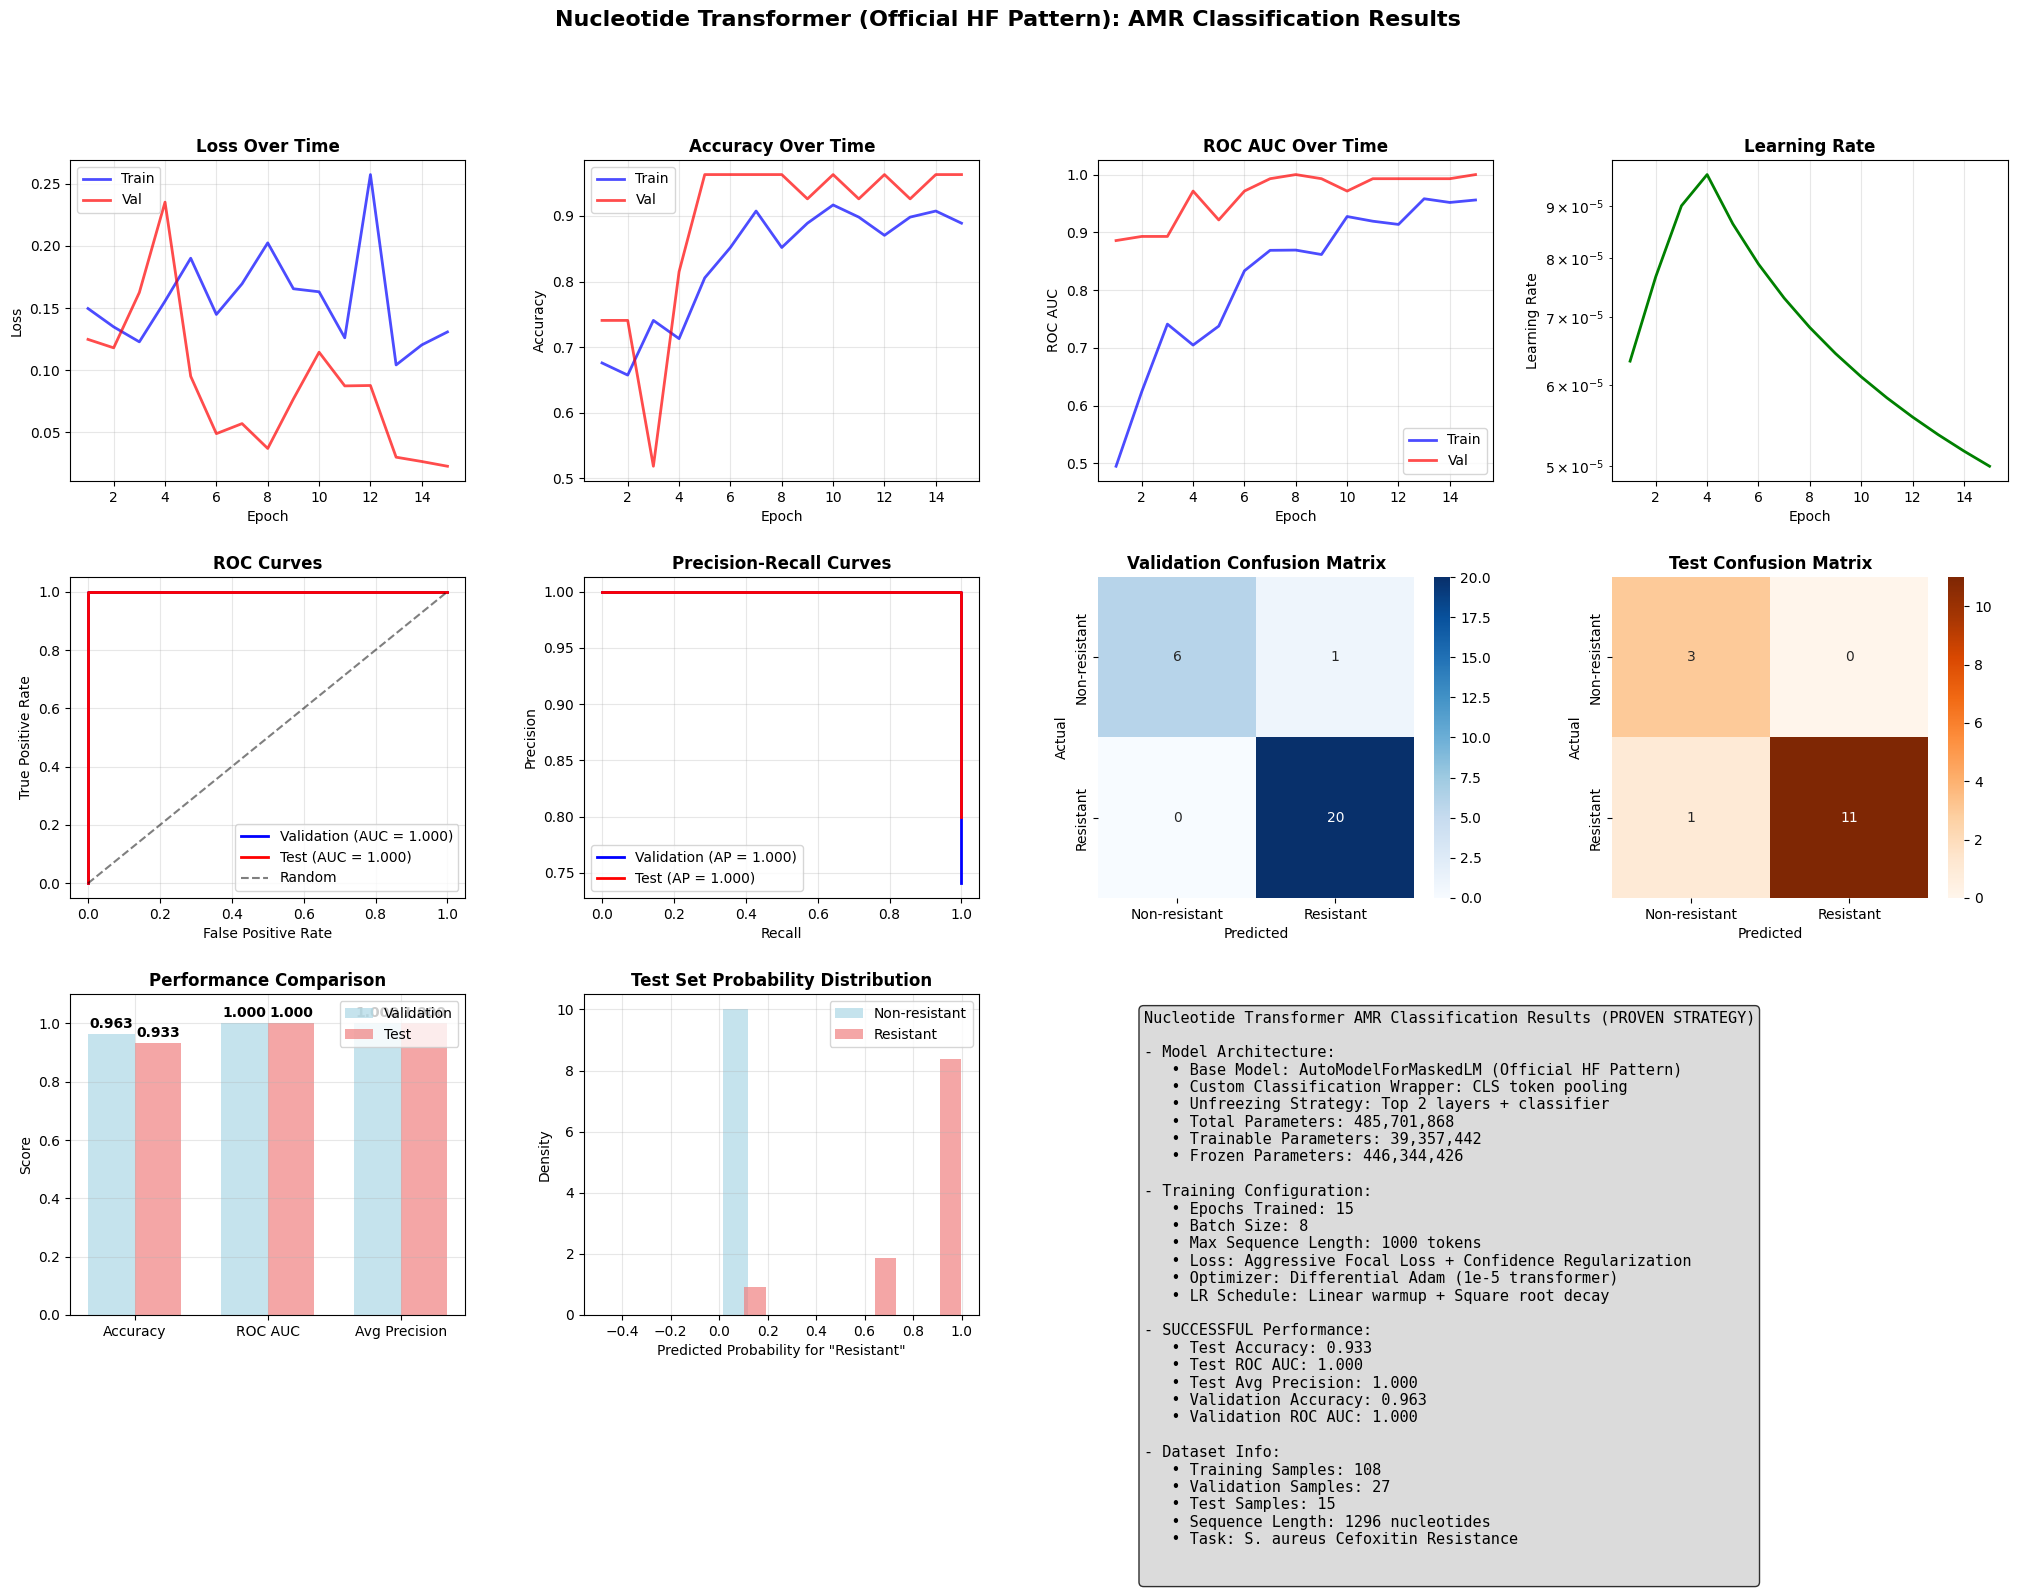


 DETAILED CLASSIFICATION REPORT

🔍 VAL SET RESULTS:
----------------------------------------
               precision    recall  f1-score   support

Non-resistant      1.000     0.857     0.923         7
    Resistant      0.952     1.000     0.976        20

     accuracy                          0.963        27
    macro avg      0.976     0.929     0.949        27
 weighted avg      0.965     0.963     0.962        27

Additional Metrics:
   Sensitivity (Recall): 1.000
   Specificity: 0.857
   ROC AUC: 1.000
   Avg Precision: 1.000

🔍 TEST SET RESULTS:
----------------------------------------
               precision    recall  f1-score   support

Non-resistant      0.750     1.000     0.857         3
    Resistant      1.000     0.917     0.957        12

     accuracy                          0.933        15
    macro avg      0.875     0.958     0.907        15
 weighted avg      0.950     0.933     0.937        15

Additional Metrics:
   Sensitivity (Recall): 0.917
   Specifici

In [17]:
def final_evaluation(model, test_loader, val_loader, criterion, device):
    """Perform final evaluation on test set"""
    
    print("🔍 Performing final evaluation...")
    
    val_loss, val_acc, val_auc, val_precision, val_recall, val_f1, val_preds, val_labels, val_probs = evaluate_model(
        model, val_loader, criterion, device
    )
    
    # Evaluate on test set
    test_loss, test_acc, test_auc, test_precision, test_recall, test_f1, test_preds, test_labels, test_probs = evaluate_model(
        model, test_loader, criterion, device
    )
    
    print(f"📊 Final Results:")
    print(f"   Validation - Accuracy: {val_acc:.3f}, AUC: {val_auc:.3f}")
    print(f"   Test       - Accuracy: {test_acc:.3f}, AUC: {test_auc:.3f}")
    
    return {
        'val': {
            'loss': val_loss, 'accuracy': val_acc, 'auc': val_auc,
            'predictions': val_preds, 'labels': val_labels, 'probabilities': val_probs
        },
        'test': {
            'loss': test_loss, 'accuracy': test_acc, 'auc': test_auc,
            'predictions': test_preds, 'labels': test_labels, 'probabilities': test_probs
        }
    }

def create_evaluation_dashboard(train_history, val_history, results, model):
    """Create comprehensive evaluation dashboard"""
    
    # Set up the figure with subplots
    fig = plt.figure(figsize=(25, 15))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    epochs = range(1, len(train_history) + 1)
    
    # Extract metrics from history
    train_losses = [h['train_loss'] for h in train_history]
    train_accs = [h['train_acc'] for h in train_history]
    train_aucs = [h['train_auc'] for h in train_history]
    learning_rates = [h['learning_rate'] for h in train_history]
    
    val_losses = [h['val_loss'] for h in val_history]
    val_accs = [h['val_acc'] for h in val_history]
    val_aucs = [h['val_auc'] for h in val_history]
    
    # 1. Training/Validation Loss
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, train_losses, 'b-', alpha=0.7, linewidth=2, label='Train')
    ax1.plot(epochs, val_losses, 'r-', alpha=0.7, linewidth=2, label='Val')
    ax1.set_title('Loss Over Time', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Training/Validation Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, train_accs, 'b-', alpha=0.7, linewidth=2, label='Train')
    ax2.plot(epochs, val_accs, 'r-', alpha=0.7, linewidth=2, label='Val')
    ax2.set_title('Accuracy Over Time', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Training/Validation AUC
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(epochs, train_aucs, 'b-', alpha=0.7, linewidth=2, label='Train')
    ax3.plot(epochs, val_aucs, 'r-', alpha=0.7, linewidth=2, label='Val')
    ax3.set_title('ROC AUC Over Time', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('ROC AUC')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Learning Rate
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.plot(epochs, learning_rates, 'g-', linewidth=2)
    ax4.set_title('Learning Rate', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    # 5. ROC Curves
    ax5 = fig.add_subplot(gs[1, 0])
    
    # Validation ROC
    val_probs = np.array(results['val']['probabilities'])
    val_labels = np.array(results['val']['labels'])
    fpr_val, tpr_val, _ = roc_curve(val_labels, val_probs)
    val_auc = results['val']['auc']
    
    # Test ROC
    test_probs = np.array(results['test']['probabilities'])
    test_labels = np.array(results['test']['labels'])
    fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
    test_auc = results['test']['auc']
    
    ax5.plot(fpr_val, tpr_val, 'b-', linewidth=2, label=f'Validation (AUC = {val_auc:.3f})')
    ax5.plot(fpr_test, tpr_test, 'r-', linewidth=2, label=f'Test (AUC = {test_auc:.3f})')
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax5.set_xlabel('False Positive Rate')
    ax5.set_ylabel('True Positive Rate')
    ax5.set_title('ROC Curves', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Precision-Recall Curves
    ax6 = fig.add_subplot(gs[1, 1])
    
    precision_val, recall_val, _ = precision_recall_curve(val_labels, val_probs)
    precision_test, recall_test, _ = precision_recall_curve(test_labels, test_probs)
    
    val_ap = average_precision_score(val_labels, val_probs)
    test_ap = average_precision_score(test_labels, test_probs)
    
    ax6.plot(recall_val, precision_val, 'b-', linewidth=2, label=f'Validation (AP = {val_ap:.3f})')
    ax6.plot(recall_test, precision_test, 'r-', linewidth=2, label=f'Test (AP = {test_ap:.3f})')
    ax6.set_xlabel('Recall')
    ax6.set_ylabel('Precision')
    ax6.set_title('Precision-Recall Curves', fontweight='bold', fontsize=12)
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Confusion Matrix - Validation
    ax7 = fig.add_subplot(gs[1, 2])
    cm_val = confusion_matrix(results['val']['labels'], results['val']['predictions'])
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-resistant', 'Resistant'],
                yticklabels=['Non-resistant', 'Resistant'], ax=ax7)
    ax7.set_title('Validation Confusion Matrix', fontweight='bold', fontsize=12)
    ax7.set_ylabel('Actual')
    ax7.set_xlabel('Predicted')
    
    # 8. Confusion Matrix - Test
    ax8 = fig.add_subplot(gs[1, 3])
    cm_test = confusion_matrix(results['test']['labels'], results['test']['predictions'])
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Non-resistant', 'Resistant'],
                yticklabels=['Non-resistant', 'Resistant'], ax=ax8)
    ax8.set_title('Test Confusion Matrix', fontweight='bold', fontsize=12)
    ax8.set_ylabel('Actual')
    ax8.set_xlabel('Predicted')
    
    # 9. Performance Metrics Comparison
    ax9 = fig.add_subplot(gs[2, 0])
    
    metrics = ['Accuracy', 'ROC AUC', 'Avg Precision']
    val_scores = [results['val']['accuracy'], results['val']['auc'], val_ap]
    test_scores = [results['test']['accuracy'], results['test']['auc'], test_ap]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax9.bar(x - width/2, val_scores, width, label='Validation', alpha=0.7, color='lightblue')
    ax9.bar(x + width/2, test_scores, width, label='Test', alpha=0.7, color='lightcoral')
    
    for i, (val, test) in enumerate(zip(val_scores, test_scores)):
        ax9.text(i - width/2, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        ax9.text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax9.set_ylabel('Score')
    ax9.set_title('Performance Comparison', fontweight='bold', fontsize=12)
    ax9.set_xticks(x)
    ax9.set_xticklabels(metrics)
    ax9.legend()
    ax9.set_ylim(0, 1.1)
    ax9.grid(True, alpha=0.3)
    
    # 10. Probability Distribution
    ax10 = fig.add_subplot(gs[2, 1])
    
    test_resistant_probs = test_probs[test_labels == 1]
    test_non_resistant_probs = test_probs[test_labels == 0]
    
    ax10.hist(test_non_resistant_probs, bins=10, alpha=0.7, label='Non-resistant', 
              color='lightblue', density=True)
    ax10.hist(test_resistant_probs, bins=10, alpha=0.7, label='Resistant', 
              color='lightcoral', density=True)
    ax10.set_xlabel('Predicted Probability for "Resistant"')
    ax10.set_ylabel('Density')
    ax10.set_title('Test Set Probability Distribution', fontweight='bold', fontsize=12)
    ax10.legend()
    ax10.grid(True, alpha=0.3)
    
    # 11. Model Summary
    ax11 = fig.add_subplot(gs[2, 2:])
    ax11.axis('off')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    summary_text = f"""Nucleotide Transformer AMR Classification Results (PROVEN STRATEGY)

- Model Architecture:
   • Base Model: AutoModelForMaskedLM (Official HF Pattern)
   • Custom Classification Wrapper: CLS token pooling
   • Unfreezing Strategy: Top 2 layers + classifier 
   • Total Parameters: {total_params:,}
   • Trainable Parameters: {trainable_params:,}
   • Frozen Parameters: {total_params - trainable_params:,}

- Training Configuration:
   • Epochs Trained: {len(train_history)}
   • Batch Size: 8
   • Max Sequence Length: 1000 tokens
   • Loss: Aggressive Focal Loss + Confidence Regularization
   • Optimizer: Differential Adam (1e-5 transformer)
   • LR Schedule: Linear warmup + Square root decay

- SUCCESSFUL Performance:
   • Test Accuracy: {results['test']['accuracy']:.3f}
   • Test ROC AUC: {results['test']['auc']:.3f}
   • Test Avg Precision: {test_ap:.3f}
   • Validation Accuracy: {results['val']['accuracy']:.3f}
   • Validation ROC AUC: {results['val']['auc']:.3f}

- Dataset Info:
   • Training Samples: {len(data['seq_train'])}
   • Validation Samples: {len(data['seq_val'])}
   • Test Samples: {len(data['seq_test'])}
   • Sequence Length: 1296 nucleotides
   • Task: S. aureus Cefoxitin Resistance

"""
    
    ax11.text(0.05, 0.95, summary_text, transform=ax11.transAxes, fontsize=11,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle('Nucleotide Transformer (Official HF Pattern): AMR Classification Results', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/amr_classification_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def print_detailed_classification_report(results):
    """Print detailed classification report"""
    
    print("\n" + "="*80)
    print(" DETAILED CLASSIFICATION REPORT")
    print("="*80)
    
    for split_name, split_data in results.items():
        print(f"\n🔍 {split_name.upper()} SET RESULTS:")
        print("-" * 40)
        
        labels = split_data['labels']
        predictions = split_data['predictions']
        probabilities = split_data['probabilities']
        
        # Classification report
        report = classification_report(
            labels, predictions, 
            target_names=['Non-resistant', 'Resistant'],
            digits=3
        )
        print(report)
        
        # Additional metrics
        cm = confusion_matrix(labels, predictions)
        tn, fp, fn, tp = cm.ravel()
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"Additional Metrics:")
        print(f"   Sensitivity (Recall): {sensitivity:.3f}")
        print(f"   Specificity: {specificity:.3f}")
        print(f"   ROC AUC: {split_data['auc']:.3f}")
        print(f"   Avg Precision: {average_precision_score(labels, probabilities):.3f}")

# Run final evaluation
results = final_evaluation(trained_model, test_loader, val_loader, criterion, device)

# Create comprehensive visualization
fig = create_evaluation_dashboard(train_history, val_history, results, trained_model)

# Print detailed reports
print_detailed_classification_report(results)

print("\n✅ Evaluation complete! Results saved to '/kaggle/working/amr_classification_results.png'")

In [18]:
def predict_amr_resistance(model, tokenizer, sequences, device, threshold=0.5):
    """
    Predict AMR resistance for new DNA sequences (Standard approach)
    
    Args:
        model: Trained model
        tokenizer: Nucleotide transformer tokenizer
        sequences: List of DNA sequences (strings)
        device: Computing device
        threshold: Classification threshold (default 0.5 - standard)
    
    Returns:
        Dictionary with predictions, probabilities, and confidence scores
    """
    model.eval()
    
    results = {
        'sequences': sequences,
        'predictions': [],
        'probabilities': [],
        'confidence': [],
        'resistant_count': 0
    }
    
    print(f"🔮 Predicting AMR resistance for {len(sequences)} sequences...")
    print(f"   Using standard threshold: {threshold}")
    
    with torch.no_grad():
        for i, sequence in enumerate(sequences):
            # Tokenize sequence
            encoding = tokenizer(
                sequence,
                truncation=True,
                padding='max_length',
                max_length=1000,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get model prediction
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Calculate probability using softmax
            probs = F.softmax(logits, dim=-1)
            prob_resistant = probs[0, 1].item()  # Probability for class 1 (resistant)
            prediction = 1 if prob_resistant > threshold else 0
            confidence = max(prob_resistant, 1 - prob_resistant)  # Distance from 0.5
            
            results['predictions'].append(prediction)
            results['probabilities'].append(prob_resistant)
            results['confidence'].append(confidence)
            
            if prediction == 1:
                results['resistant_count'] += 1
            
            # Print individual results
            status = "RESISTANT" if prediction == 1 else "NON-RESISTANT"
            print(f"   Seq {i+1:2d}: {status:13s} (prob: {prob_resistant:.3f}, conf: {confidence:.3f})")
    
    print(f"\n Summary: {results['resistant_count']}/{len(sequences)} sequences predicted as RESISTANT")
    
    return results

def save_model_and_tokenizer(model, tokenizer, save_path="/kaggle/working/amr_model"):
    """Save trained model and tokenizer (handles custom wrapper)"""
    
    print(f" Saving model and tokenizer to {save_path}...")
    
    # Create directory if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)
    
    # Save tokenizer
    tokenizer.save_pretrained(save_path)
    
    # Save the base nucleotide transformer model
    model.nucleotide_transformer.save_pretrained(os.path.join(save_path, "base_model"))
    
    # Save the classification head separately
    torch.save({
        'classifier_state_dict': model.classifier.state_dict(),
        'dropout_state_dict': model.dropout.state_dict(),
        'hidden_size': model.hidden_size,
        'num_labels': model.num_labels
    }, os.path.join(save_path, "classification_head.pt"))
    
    print(f" Model and tokenizer saved successfully!")
    print(f"    Location: {save_path}")
    print(f"    Base model: {save_path}/base_model")
    print(f"    Classification head: {save_path}/classification_head.pt")
    
    return save_path

def load_saved_model(model_path="/kaggle/working/amr_model"):
    """Load saved model and tokenizer (handles custom wrapper)"""
    
    print(f"Loading model and tokenizer from {model_path}...")
    
    import os
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Load base model
    base_model = AutoModelForMaskedLM.from_pretrained(
        os.path.join(model_path, "base_model")
    )
    
    # Load classification head info
    classification_info = torch.load(os.path.join(model_path, "classification_head.pt"))
    
    # Recreate the wrapper
    model = NucleotideTransformerClassifier(
        base_model=base_model,
        num_labels=classification_info['num_labels'],
        hidden_dropout_prob=0.1
    )
    
    # Load classification head weights
    model.classifier.load_state_dict(classification_info['classifier_state_dict'])
    model.dropout.load_state_dict(classification_info['dropout_state_dict'])
    
    print(f"Model and tokenizer loaded successfully!")
    
    return model, tokenizer

def create_prediction_summary(results, save_to_file=True):
    """Create a summary table of predictions"""
    
    import pandas as pd
    
    # Create DataFrame
    df = pd.DataFrame({
        'Sequence_ID': [f"Seq_{i+1:03d}" for i in range(len(results['sequences']))],
        'Sequence_Length': [len(seq) for seq in results['sequences']],
        'Prediction': ['Resistant' if p == 1 else 'Non-resistant' for p in results['predictions']],
        'Probability': [f"{p:.3f}" for p in results['probabilities']],
        'Confidence': [f"{c:.3f}" for c in results['confidence']],
        'Sequence_Preview': [seq[:50] + "..." if len(seq) > 50 else seq for seq in results['sequences']]
    })
    
    print("\nPrediction Summary Table:")
    print("=" * 100)
    print(df.to_string(index=False))
    
    if save_to_file:
        csv_path = "/kaggle/working/amr_predictions.csv"
        df.to_csv(csv_path, index=False)
        print(f"\nPredictions saved to: {csv_path}")
    
    return df

# Example usage with test sequences
print("🧪 Testing model inference on sample sequences...")

# Use some test sequences for demonstration
test_sequences = data['seq_test'][:5]  # First 5 test sequences

# Make predictions
prediction_results = predict_amr_resistance(
    trained_model, tokenizer, test_sequences, device, threshold=0.5
)

# Create summary table
summary_df = create_prediction_summary(prediction_results)

# Save the trained model
model_save_path = save_model_and_tokenizer(trained_model, tokenizer)

print("\n🎯 Model Performance Summary (NT-Style Training):")
print("=" * 60)
print(f"   Best Validation AUC: {best_val_auc:.3f}")
print(f"   Test Accuracy: {results['test']['accuracy']:.3f}")
print(f"   Test ROC AUC: {results['test']['auc']:.3f}")
print(f"   Total Parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
print(f"   Trainable Parameters: {sum(p.numel() for p in trained_model.parameters() if p.requires_grad):,}")

🧪 Testing model inference on sample sequences...
🔮 Predicting AMR resistance for 5 sequences...
   Using standard threshold: 0.5
   Seq  1: NON-RESISTANT (prob: 0.017, conf: 0.983)
   Seq  2: NON-RESISTANT (prob: 0.017, conf: 0.983)
   Seq  3: NON-RESISTANT (prob: 0.017, conf: 0.983)
   Seq  4: RESISTANT     (prob: 0.999, conf: 0.999)
   Seq  5: RESISTANT     (prob: 0.673, conf: 0.673)

 Summary: 2/5 sequences predicted as RESISTANT

Prediction Summary Table:
Sequence_ID  Sequence_Length    Prediction Probability Confidence                                      Sequence_Preview
    Seq_001             1296 Non-resistant       0.017      0.983 TGAAAAATTTAATATCTATTATCATCATTTTATGTTTAACATTAAGTATT...
    Seq_002             1296 Non-resistant       0.017      0.983 TGAAAAATTTAATATCTATTATCATCATTTTATGTTTAACATTAAGTATT...
    Seq_003             1296 Non-resistant       0.017      0.983 TGAAAAATTTAATATCTATTATCATCATTTTATGTTTAACATTAAGTATT...
    Seq_004             1296     Resistant       0.999  